Link dataset: https://www.kaggle.com/datasets/aryashah2k/credit-card-customer-data/code

### Significado de variables
- **Sl_No:** Número de identificación de serie del cliente: Sirve para indexar valores
- **Customer Key** 
- **Avg_Credit_Limit:** Límite promedio de la tarjeta de crédito para el cliente
- **Total_Credit_Cards:**  Total de tarjetas de crédito del cliente
- **Total_visits_bank:**  Número total de visitas del cliente al banco
- **Total_visits_online:**  Total de visitas en línea del cliente del banco
- **Total_calls_made:** Total de llamadas realizadas por el cliente al banco

En este notebook se aplicarán tres técnicas de clustering sobre el mismo conjunto de datos y, al final, se compararán sus resultados.

## Técnicas de clustering

### k-means
- Particiona los datos en _k_ clusters, minimizando la suma de distancias al cuadrado entre cada punto y el centroide de su cluster.  
- Requiere especificar de antemano el número de clusters (_k_).  
- Ideal para clusters de forma convexa y similar tamaño.

### DBSCAN
- Clustering basado en densidad: agrupa puntos con alta densidad local y etiqueta como “ruido” los puntos dispersos.  
- No requiere número de clusters previo, pero sí dos parámetros: _eps_ (radio de vecindad) y _min_samples_ (mínimo de puntos).  
- Capta clusters de forma arbitraria y es robusto al ruido.

### BFR (Bradley-Fayyad-Reina)
- Algoritmo para clustering de grandes volúmenes de datos, basado en modelos gaussianos parciales.  
- Resume cada cluster con estadísticas suficientes (_CF vectors_) y procesa datos por _chunks_.  
- Muy eficiente en memoria y tiempo para datasets que no caben en memoria completa.

## Flujo de trabajo
1. **Carga y preprocesamiento**  
   - Limpieza, escalado y reducción de dimensionalidad (opcional).  
2. **Entrenar k-means**  
3. **Entrenar DBSCAN**  
4. **Entrenar BFR**  
5. **Comparar resultados**

## Comparación de técnicas
Para cuantificar la calidad de agrupamiento y compararlas de forma homogénea, utilizaremos:

**Coeficiente de Silhouette**  
- Mide la cohesión interna (distancia media al propio cluster) frente a la separación con otros clusters.  
- Rango: \(-1\) (mal asignado) a \(+1\) (cluster bien definido).  
- Aplicable a **k-means**, **DBSCAN** (considerando o ignorando ruido) y **BFR**.  
- Implementación recomendada:  
  ```python
  from sklearn.metrics import silhouette_score
  score = silhouette_score(X, labels)


In [539]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, DBSCAN

### 1. Carga y procesamiento

In [540]:
df = pd.read_csv('Credit Card Customer Data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [541]:
# Quitamos Custumer key del dataframe
df.drop(columns=['Customer Key'], inplace=True)
# Quitamos SI_No del dataframe
df.drop(columns=['Sl_No'], inplace=True)

df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [542]:
# Veamos cuantos son los datos nulos
print(df.isnull().sum())

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64


In [543]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


## Análisis de la distribución de **Avg_Credit_Limit**

- **Mediana (18 000)**  
  La “cintura” del violin y la transición de color en la tira de calor confirman que la mitad de los clientes tiene un límite de crédito ≤ 18 000.

- **Rango intercuartílico (10 000 – 48 000)**  
  El grueso de la densidad (la parte más ancha del violin) está entre 10 000 y 48 000, mostrando dónde se concentra el 50 % central de los datos.

- **Asimetría positiva**  
  La nube se estrecha rápidamente hacia valores altos y la cola derecha se alarga hasta 200 000, indicando que unos pocos clientes disponen de límites muy altos.

- **Valores atípicos**  
  Se aprecian puntos aislados por encima de los 100 000, que reflejan unos cuantos casos extremos.

- **Variabilidad elevada (std ≈ 37 625)**  
  La dispersión es amplia, lo que sugiere heterogeneidad en los límites otorgados a los clientes.

### Ver el grafico a continuación

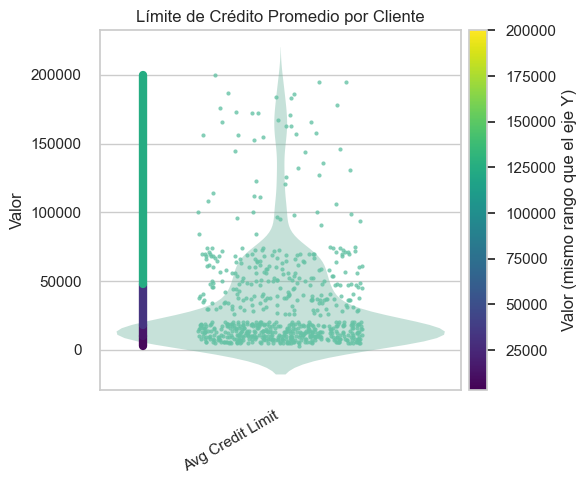

In [544]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

col = 'Avg_Credit_Limit'
data = df[[col]]

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
palette = sns.color_palette("Set2", 1)
norm = Normalize(vmin=data[col].min(), vmax=data[col].max())
ax = plt.gca()


x = np.zeros_like(data[col], dtype=float)
sns.violinplot(y=data[col], x=x, inner=None,
               color=palette[0], width=.6, linewidth=0, alpha=.4)
sns.stripplot(y=data[col], x=x, size=3,
              color=palette[0], jitter=.15, alpha=.8)


stats = data[col].describe()
q = stats[['min', '25%', '50%', '75%', 'max']].values
y0, y1 = q[:-1], q[1:]
for y_start, y_end in zip(y0, y1):
    ax.plot([-0.25, -0.25], [y_start, y_end], lw=6,
            color=plt.cm.viridis(norm((y_start + y_end) / 2)))


ax.set_xticks([0])
ax.set_xticklabels([col.replace('_', ' ')], rotation=30, ha='right')
ax.set_ylabel("Valor")
ax.set_title("Límite de Crédito Promedio por Cliente")


sm = ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=.02)
cbar.set_label("Valor (mismo rango que el eje Y)")

plt.tight_layout()
plt.show()

## Insights del Clustermap de Correlaciones

- **Cluster 1: Capacidad crediticia**  
  - `Avg_Credit_Limit` y `Total_Credit_Cards` se agrupan muy pronto (r≈0.61), indicando que los clientes con más tarjetas también suelen tener límites promedios mayores.

- **Cluster 2: Banca digital**  
  - `Total_visits_online` se une enseguida al grupo de crédito (r≈0.55 con Avg_Credit_Limit), lo que sugiere que los clientes con mejor perfil crediticio utilizan más la banca en línea.

- **Cluster 3: Canal presencial**  
  - `Total_visits_bank` forma su propio remanso, con correlaciones bajas o negativas frente a las métricas de crédito (r≈–0.10) y frente a la banca online (r≈–0.55), señalando un comportamiento de “todo-o-nada” entre canales.

- **Cluster 4: Llamadas al call center**  
  - `Total_calls_made` queda aislado en la cúspide: presenta correlaciones negativas fuertes con `Total_Credit_Cards` (r≈–0.65) y moderadas con visitas a sucursal (r≈–0.51), mostrando que más llamadas no implica ni más crédito ni más visitas físicas.

 **Conclusión**  
 Aparecen dos grandes familias:  
 1. **Crédito + Digital** (alto crédito ↔ uso intenso de banca online)  
 2. **Atención tradicional** (visitas y llamadas) con dinámicas casi opuestas al cluster de crédito.  


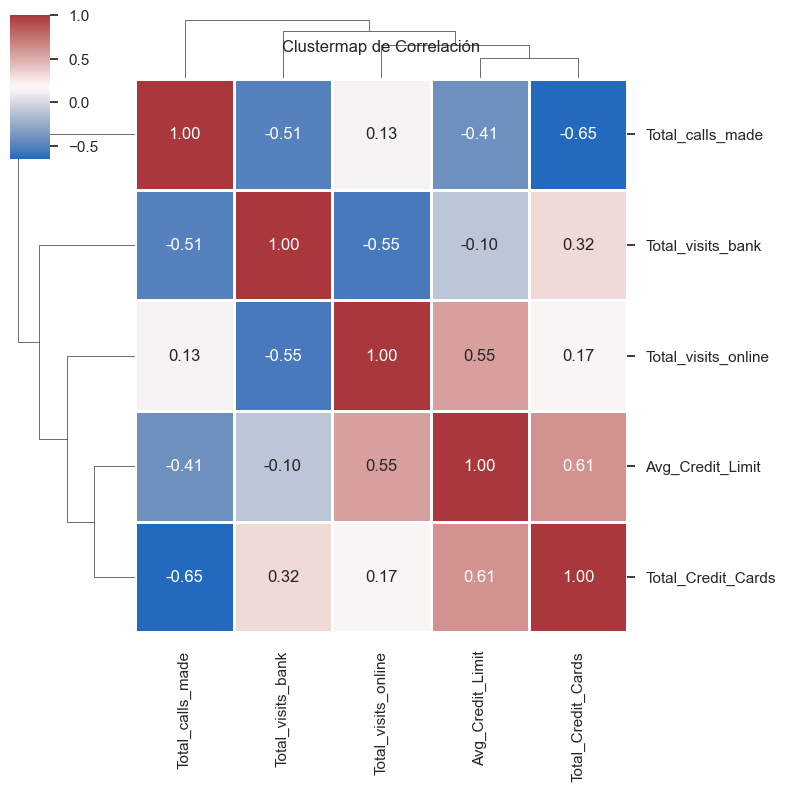

In [545]:
corr = df.corr()

# Dibuja el clustermap
sns.set(font_scale=1)
g = sns.clustermap(
    corr,
    cmap="vlag",
    linewidths=.75,
    figsize=(8, 8),
    annot=True,
    fmt=".2f",
    cbar_pos=(0.02, .8, .05, .18),
    dendrogram_ratio=(.2, .1),
    yticklabels=True,
    xticklabels=True
)
g.ax_heatmap.set_title("Clustermap de Correlación", pad=20)
plt.show()

In [546]:
# Creamos una nueva columna que se denominara 'Recency' 
df['Recency'] = df['Total_visits_bank'] + df['Total_visits_online'] + df['Total_calls_made']
# Esta variable nos indica la cantidad de interacciones que ha tenido el cliente con el banco en los últimos meses.
# Creamos una nueva columna que se denominara 'Credit_Usage'
df['Credit_Usage'] = df['Avg_Credit_Limit'] / (df['Total_Credit_Cards'] + 1)
# Esta variable nos indica el uso promedio del crédito por tarjeta.

df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Recency,Credit_Usage
0,100000,2,1,1,0,2,33333.333333
1,50000,3,0,10,9,19,12500.000000
2,50000,7,1,3,4,8,6250.000000
3,30000,5,1,1,4,6,5000.000000
4,100000,6,0,12,3,15,14285.714286


In [547]:
# Ahora escalamos las variables para que tengan la misma importancia
from sklearn.preprocessing import MinMaxScaler
# hacemos una copia del dataframe para no modificar el original
df_scaled = df[['Avg_Credit_Limit','Total_Credit_Cards','Recency', 'Credit_Usage']]
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_scaled)
df_scaled.shape

(660, 4)

## 2. Entrenar K-means

In [548]:
kmeans =KMeans(n_clusters=4, max_iter=300, init='k-means++', random_state=42)
y_kmeans= kmeans.fit_predict(df_scaled)

df['kmeans_cluster']= kmeans.labels_
df['kmeans_cluster'].value_counts()

kmeans_cluster
0    211
2    208
1    192
3     49
Name: count, dtype: int64

### Interpretación métrica: `kmeans.inertia_`

- **Baja inercia ⇒ clusters compactos**  
  Los puntos están, en promedio, más cerca de sus centroides.

- **Alta inercia ⇒ clusters dispersos**  
  Mayor variabilidad interna dentro de cada cluster.

- Al **aumentar** \(k\), la inercia siempre **disminuye** (cada punto puede quedar más cerca de algún centroide).


In [549]:
kmeans.inertia_

29.90601794683751

### Coeficiente de Silhouette para K-means

In [550]:
SParaK = silhouette_score(df_scaled, kmeans.labels_)
print(f"Silhouette Score para KMeans: {SParaK:.4f}")

Silhouette Score para KMeans: 0.3286


### Método del Codo (Elbow Method)

El Método del Codo es una técnica visual para seleccionar el número óptimo de clusters \(k\) en k-means. La idea central es:

1. **Calcular la inercia** (WCSS – Within-Cluster Sum of Squares) para distintos valores de \(k\).  
2. **Graficar** la inercia en función de \(k\).  
3. **Detectar el “codo”** en la curva: el punto donde la reducción de la inercia al aumentar \(k\) deja de ser significativa.

- A la izquierda del codo, cada cluster adicional aporta gran mejora (disminuye mucho la inercia).  
- A la derecha del codo, añadir más clusters aporta poca ganancia (la inercia apenas baja).  
- El valor de \(k\) en el codo ofrece un buen compromiso entre **compactación** (baja inercia) y **simplicidad** (pocos clusters).


<Axes: >

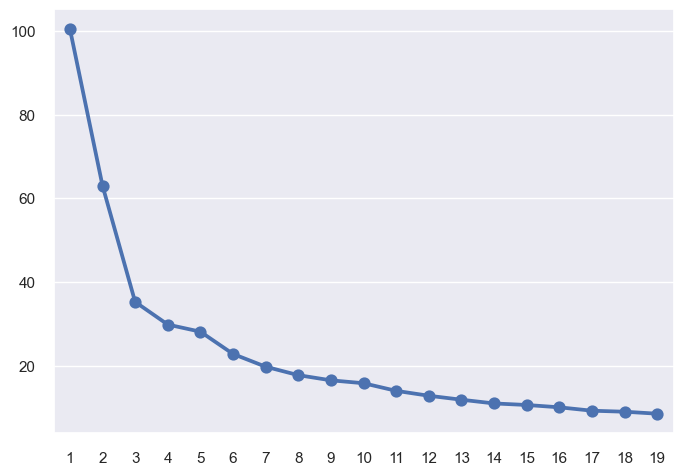

In [551]:
# Diccionario para almacenar la inercia (WCSS) por cada k
wcss = {}

# Probar valores de k desde 1 hasta 19
for k in range(1, 20):
    # Configurar y ajustar el modelo KMeans
    kmeans = KMeans(
        n_clusters=k,        # número de clusters
        max_iter=300,        # iteraciones máximas
        init='k-means++',    # inicialización de centroides
        random_state=42      # semilla para reproducibilidad
    )
    kmeans.fit(df_scaled)               # ajustar el modelo a los datos
    wcss[k] = kmeans.inertia_   # guardar la inercia (WCSS) en el diccionario

# Graficar inercia vs. número de clusters usando seaborn
sns.pointplot(
    x=list(wcss.keys()),    # lista de valores de k
    y=list(wcss.values()),  # lista de inercia correspondiente
    marker='o'
)

Al observar la curva de **inercia (WCSS) vs. número de clusters (k)**:

- **Descenso pronunciado inicial**  
  - De \(k=1\) a \(k=2\): la inercia cae de ~250 a ~185.  
  - De \(k=2\) a \(k=3\): nuevo gran descenso, de ~185 a ~85.  
  Esto indica que pasar de 1 a 3 clusters aporta enormes ganancias en compactar los datos.

- **Zona de “codo” (punto de inflexión)**  
  - Tras \(k=3\), la pendiente se suaviza:  
    - \(k=4\) ≈ 65,  
    - \(k=5\) ≈ 60,  
    - más allá de \(k=5\), cada cluster adicional reduce la inercia muy levemente.  
  - El **codo** se sitúa alrededor de **\(k=3\) o \(k=4\)**, donde la mejora empieza a estabilizarse.

- **Selección óptima de \(k\)**  
  - Elegir **\(k=3\)** o **\(k=4\)** suele ser ideal:  
    - Captura la mayor parte de la variabilidad interna.  
    - Evita un número excesivo de clusters que compliquen la interpretación.


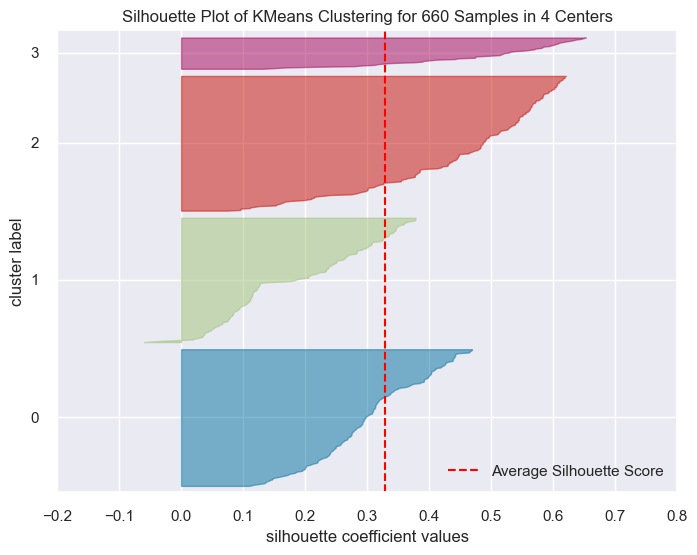

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [552]:
from yellowbrick.cluster import SilhouetteVisualizer

# Definir el número de clusters
n_clusters = 4

# Inicializar el modelo KMeans con semilla para reproducibilidad
kmeans = KMeans(
    n_clusters=n_clusters,
    init='k-means++',
    random_state=42
)

# Opcional: ajustar el tamaño de la figura
plt.figure(figsize=(8, 6))

# Crear el visualizador de Silhouette
visualizer = SilhouetteVisualizer(
    kmeans,
    colors='yellowbrick'
)

# Ajustar el visualizador a los datos (entraña fit y predict)
visualizer.fit(df_scaled)
visualizer.ax.set_title(f"Diagrama de Silhouette para KMeans (k={n_clusters})") 
visualizer.show()


### 3. Entrenar DBscan 

### Búsqueda de parámetros óptimos para DBSCAN

#### Objetivo
Realizar una exploración exhaustiva de combinaciones de **eps** (radio de vecindad) y **min_samples** (mínimo de puntos) para el algoritmo DBSCAN, con el fin de maximizar la puntuación de Silhouette sobre el dataset escalado.

#### Parámetros evaluados
- **eps:** lista de radios de vecindad a probar.  
- **min_samples:** lista de valores mínimos de puntos para formar un clúster.

#### Variables de control
- **best_score:** almacena la mejor puntuación de Silhouette encontrada.  
- **best_eps / best_m:** guardan los valores de eps y min_samples que producen esa mejor puntuación.

#### Flujo de trabajo
1. **Recorrer todas las combinaciones** de eps y min_samples mediante bucles anidados.  
2. **Ajustar DBSCAN** con la combinación actual y obtener las etiquetas de cluster.  
3. **Contar clusters válidos**, ignorando el ruido (etiqueta –1), y descartar configuraciones que produzcan un único cluster o ninguno.  
4. **Calcular la puntuación de Silhouette** para medir la cohesión interna y la separación entre clusters.  
5. **Actualizar los parámetros óptimos** si la puntuación actual supera a la mejor registrada, e imprimir inmediatamente la nueva mejor configuración.


In [553]:
import itertools
# Definición de parámetros a evaluar
radios_eps    = [ 0.01, 0.02, 0.03, 0.05, 0.08, 0.05, 0.015, 0.025]
min_muestras  = [5, 8, 10, 15, 16,18, 20]

#  Variables para llevar el mejor resultado
mejor_puntuacion = -1
mejor_eps        = None
mejor_min        = None

# Exploración de todas las combinaciones
for eps_val, min_val in itertools.product(radios_eps, min_muestras):
    dbscan    = DBSCAN(eps=eps_val, min_samples=min_val)
    etiquetas = dbscan.fit_predict(df_scaled)

    # Verificar si hay al menos un cluster
    if len(set(etiquetas)) <= 1:
        continue  # Si no hay clusters, saltar a la siguiente combinación

    # Calcular la puntuación de Silhouette
    puntuacion = silhouette_score(df_scaled, dbscan.labels_)
    
    # Actualizar mejor configuración
    if puntuacion > mejor_puntuacion:
        mejor_puntuacion = puntuacion
        mejor_eps = eps_val
        mejor_min = min_val

# Mostrar la mejor combinación encontrada
print(f"Mejor puntuación Silhouette: {mejor_puntuacion:.4f}")
print(f"eps óptimo = {mejor_eps}")
print(f"min_samples óptimo = {mejor_min}")

Mejor puntuación Silhouette: 0.0580
eps óptimo = 0.08
min_samples óptimo = 5


In [554]:
dbscan = DBSCAN(eps=0.08, min_samples=5)
y_db= dbscan.fit_predict(df_scaled)


### Coeficiente de Silhouette para DBscan

In [555]:
SParaDB = silhouette_score(df_scaled,dbscan.labels_)
print(f"Silhouette Score para DBSCAN: {SParaDB:.4f}")

Silhouette Score para DBSCAN: 0.0580


In [556]:
# Veamos cuantas etiquetas nos ha dado DBSCAN
df['dblabel']= dbscan.labels_
df['dblabel'].value_counts()

dblabel
 3    149
 7    114
 0     91
-1     69
 1     66
 5     61
 2     51
 4     51
 6      8
Name: count, dtype: int64

In [557]:
etiquetas_unicas = np.unique(y_db)
print(f"Cantidad de etiquetas únicas: {len(etiquetas_unicas)}")

Cantidad de etiquetas únicas: 9


## Visualización de clusters con DBSCAN

Este gráfico muestra cómo el algoritmo **DBSCAN** ha agrupado a los clientes según:
- **Eje X:** número total de tarjetas de crédito.
- **Eje Y:** recencia, es decir, días transcurridos desde su última interacción.


**Interpretación rápida:**  
- Identifica grupos de clientes con patrones similares de crédito y recencia.  
- Observa si existen clientes atípicos (ruido) o agrupaciones densas de comportamiento.  
- Útil para diseñar estrategias de retención o segmentación basada en uso de la tarjeta.


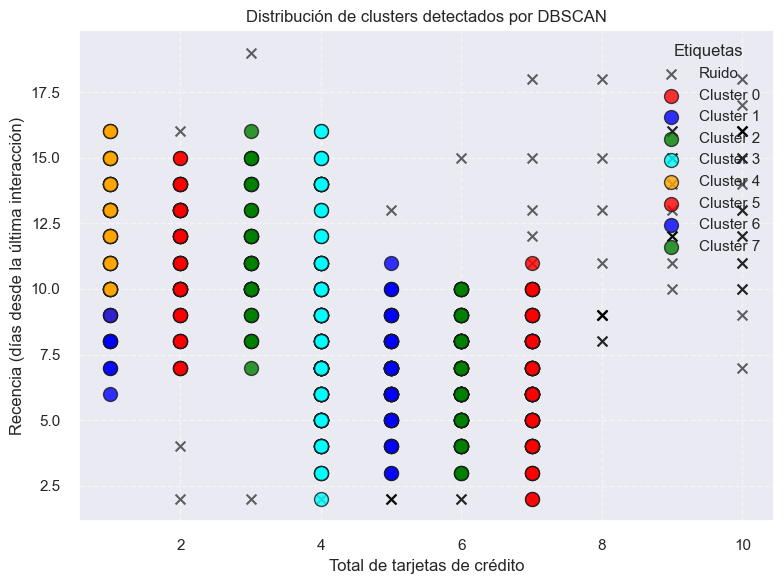

In [558]:
# Tamaño de la figura
plt.figure(figsize=(8, 6))

# Definir paleta de colores para clusters (el ruido se pinta en gris)
colores = ["red", "blue", "green", "cyan", "orange"]

# Determinar etiquetas únicas (-1 = ruido)
etiquetas_unicas = np.unique(y_db)

for etiqueta in etiquetas_unicas:
    # Subconjunto de datos para esta etiqueta
    datos_cluster = df[y_db == etiqueta]
    
    if etiqueta == -1:
        # Graficar el ruido con 'x' y color gris
        plt.scatter(
            datos_cluster['Total_Credit_Cards'],
            datos_cluster['Recency'],
            s=50,
            c='black',
            marker='x',
            label='Ruido',
            alpha=0.6
        )
    else:
        # Graficar cada cluster con color y borde negro
        color = colores[int(etiqueta) % len(colores)]
        plt.scatter(
            datos_cluster['Total_Credit_Cards'],
            datos_cluster['Recency'],
            s=100,
            c=color,
            edgecolors='k',
            label=f"Cluster {etiqueta}",
            alpha=0.8
        )

# Etiquetas y estilo
plt.xlabel("Total de tarjetas de crédito")
plt.ylabel("Recencia (días desde la última interacción)")
plt.title("Distribución de clusters detectados por DBSCAN")
plt.legend(title="Etiquetas", loc="upper right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Algoritmo BFR (Bradley–Fayyad–Reina)

## ¿Qué es BFR?
BFR es un **método de clustering escalable** diseñado para procesar grandes conjuntos de datos que no caben en memoria. Opera en fragmentos (_chunks_) y mantiene **estadísticas suficientes** que permiten resumir cada cluster sin almacenar todos los puntos.

### Conjuntos que maneja
| Conjunto | Significado | Contenido |
|----------|-------------|-----------|
| **DS** (Discard Set)     | Clusters consolidados | `(N, SUM, SUMSQ)`<br>Se descartan los puntos originales. |
| **CS** (Compression Set) | Sub-clusters más pequeños, aún no definitivos | También con estadísticas suficientes. |
| **RS** (Retained Set)    | Puntos considerados ruido o insuficientes para formar cluster | Lista de puntos crudos. |

### Flujo
1. **Primer bloque**  
   - Se ejecuta _k-means_ para obtener los clusters iniciales (DS).  
2. **Bloque siguiente**  
   1. Asignar cada punto al DS más cercano usando **distancia Mahalanobis**.  
   2. Si no encaja, intentar con los clusters del CS.  
   3. Los puntos que siguen sin encajar van al RS.  
3. **Re-clustering de RS**  
   - Cuando RS crece, se aplica k-means para extraer nuevos CS.  
4. **Fusión de CS**  
   - Los CS muy próximos entre sí se fusionan.  
5. **Al finalizar**  
   - Se asignan etiquetas finales a todos los puntos comparando con DS y (opcionalmente) CS; RS queda etiquetado como `-1`.

---

## Sección de código

La clase **`BFR`** implementa el algoritmo desde cero:

| Método | Propósito |
|--------|-----------|
| `__init__` | Inicializa parámetros clave (k, umbral, etc.). |
| `_init_clusters` | Ejecuta un k-means ++ sencillo para crear los clusters DS del primer bloque. |
| `_cluster_stats` / `_centroid_variance` | Calcula estadísticas y centroides de forma incremental. |
| `_mahalanobis_dist` | Distancia Mahalanobis (criterio de pertenencia). |
| `partial_fit(chunk)` | Procesa cada bloque: asigna a DS/CS/RS y actualiza estadísticas. |
| `_recluster_RS()` | Re-clustering del RS para generar nuevos CS. |
| `_merge_CS()` | Fusiona CS cercanos para evitar redundancias. |
| `finalize(data)` | Devuelve etiquetas finales tras procesar todos los bloques. |

### Uso mínimo
```python
bfr = BFR(n_clusters=8)
for chunk in stream_de_datos:     # procesar bloques secuenciales
    bfr.partial_fit(chunk)

labels = bfr.finalize(datos_completos)


In [559]:
from collections import defaultdict
from scipy.spatial.distance import mahalanobis


class BFR:
    def __init__(self, n_clusters: int, threshold: float = None, random_state: int = 42):

        self.k = n_clusters
        self.threshold = threshold
        self.random_state = random_state

        # Conjuntos principales BFR
        self.DS = {}          # {cluster_id: (N, SUM, SUMSQ)}
        self.CS = {}          # {cluster_id: (N, SUM, SUMSQ)}
        self.RS = []          # puntos ruidosos retenidos
        self.labels_ = None   # etiquetas finales

    def _init_clusters(self, chunk: np.ndarray):

        np.random.seed(self.random_state)
        n_samples, d = chunk.shape

        # Elegir el primer centroide al azar
        centroids = [chunk[np.random.randint(0, n_samples)]]

        # Elegir los k-1 centroides restantes
        for _ in range(1, self.k):
            dist_sq = np.min(
                [np.sum((chunk - c) ** 2, axis=1) for c in centroids], axis=0
            )
            prob = dist_sq / dist_sq.sum()
            next_idx = np.random.choice(n_samples, p=prob)
            centroids.append(chunk[next_idx])

        centroids = np.array(centroids)

        # Asignar puntos al centroide más cercano (euclídea)
        labels = np.argmin(
            np.linalg.norm(chunk[:, None, :] - centroids[None, :, :], axis=2), axis=1
        )

        # Guardar estadísticas suficientes en DS
        for cid in range(self.k):
            pts = chunk[labels == cid]
            N = len(pts)
            if N == 0:
                continue
            SUM = pts.sum(axis=0)
            SUMSQ = (pts ** 2).sum(axis=0)
            self.DS[cid] = (N, SUM, SUMSQ)

    def _cluster_stats(self, points: np.ndarray):

        N = len(points)
        SUM = points.sum(axis=0)
        SUMSQ = (points ** 2).sum(axis=0)
        return N, SUM, SUMSQ

    def _centroid_variance(self, stats):

        N, SUM, SUMSQ = stats
        centroid = SUM / N
        variance = SUMSQ / N - (centroid ** 2)
        # Evitar varianza cero
        variance[variance == 0] = 1e-10
        return centroid, variance

    def _mahalanobis_dist(self, point, stats):

        centroid, var = self._centroid_variance(stats)
        diff = point - centroid
        return np.sqrt(np.sum((diff ** 2) / var))


    def partial_fit(self, chunk: np.ndarray):
        """
        Procesa un bloque de datos y actualiza DS, CS y RS.
        El primer bloque inicializa los clusters; los siguientes se procesan
        de forma incremental.
        """
        d = chunk.shape[1]
        if self.threshold is None:
            self.threshold = 2 * np.sqrt(d)

        #  Si DS vacío, inicializar
        if not self.DS:
            self._init_clusters(chunk)
            return

        # Contenedores temporales
        new_RS = []

        # 2) Intentar asignar cada punto del bloque 
        for p in chunk:
            # 2.a) buscar cluster adecuado en DS
            assigned = False
            for cid, stats in self.DS.items():
                if self._mahalanobis_dist(p, stats) < self.threshold:
                    # Actualizar estadísticas DS
                    N, SUM, SUMSQ = stats
                    self.DS[cid] = (N + 1, SUM + p, SUMSQ + p ** 2)
                    assigned = True
                    break

            if assigned:
                continue

            # 2.b) intentar asignar a CS
            for cid, stats in self.CS.items():
                if self._mahalanobis_dist(p, stats) < self.threshold:
                    N, SUM, SUMSQ = stats
                    self.CS[cid] = (N + 1, SUM + p, SUMSQ + p ** 2)
                    assigned = True
                    break

            if not assigned:
                new_RS.append(p)

        # Agregar nuevos puntos de ruido
        if new_RS:
            self.RS.extend(new_RS)

        # Si RS crece, intentar reclusterizarla 
        if len(self.RS) >= 50:  # umbral arbitrario
            self._recluster_RS()

        #Fusionar CS entre sí
        self._merge_CS()

    def _recluster_RS(self):

        rs_pts = np.array(self.RS)
        k_rs = max(2, len(rs_pts) // 10)  # heurística

        # k-means ++ rápido para RS
        centroids = rs_pts[np.random.choice(len(rs_pts), k_rs, replace=False)]
        for _ in range(5):  # pocas iteraciones
            labels = np.argmin(
                np.linalg.norm(rs_pts[:, None, :] - centroids[None, :, :], axis=2), axis=1
            )
            new_centroids = np.array(
                [rs_pts[labels == j].mean(axis=0) if np.any(labels == j) else centroids[j]
                 for j in range(k_rs)]
            )
            if np.allclose(centroids, new_centroids):
                break
            centroids = new_centroids

        # Convertir clusters en CS
        remaining_RS = []
        for j in range(k_rs):
            cluster_points = rs_pts[labels == j]
            if len(cluster_points) < 2:
                remaining_RS.extend(cluster_points)
            else:
                cid = max(self.CS.keys(), default=-1) + 1
                self.CS[cid] = self._cluster_stats(cluster_points)
        self.RS = remaining_RS

    def _merge_CS(self):
        merged = True
        while merged:
            merged = False
            cs_ids = list(self.CS.keys())

            # Recorremos pares de clusters (cid1, cid2)
            for i in range(len(cs_ids)):
                for j in range(i + 1, len(cs_ids)):
                    cid1, cid2 = cs_ids[i], cs_ids[j]

                    # Centroides de ambos CS
                    centroid2, _ = self._centroid_variance(self.CS[cid2])

                    # Distancia Mahalanobis del centroide2 al CS1
                    dist = self._mahalanobis_dist(centroid2, self.CS[cid1])

                    # Si están lo bastante cerca → fusionar
                    if dist < self.threshold:
                        N1, S1, SQ1 = self.CS[cid1]
                        N2, S2, SQ2 = self.CS[cid2]
                        self.CS[cid1] = (N1 + N2, S1 + S2, SQ1 + SQ2)
                        del self.CS[cid2]
                        merged = True
                        break   # reiniciar búsqueda tras la fusión
                if merged:
                    break


    def finalize(self, data: np.ndarray):
        n_samples = data.shape[0]
        self.labels_ = np.full(n_samples, -1, dtype=int)

        # Mapear índices de clusters DS a etiquetas finales
        ds_centroids = {
            cid: self._centroid_variance(stats)[0] for cid, stats in self.DS.items()
        }

        # Asignar puntos al DS o CS más cercano (Mahalanobis)
        for idx, p in enumerate(data):
            best_cid = None
            best_dist = np.inf

            # Evaluar DS
            for cid, stats in self.DS.items():
                d = self._mahalanobis_dist(p, stats)
                if d < best_dist:
                    best_dist, best_cid = d, cid

            # Evaluar CS (opcional)
            for cid, stats in self.CS.items():
                d = self._mahalanobis_dist(p, stats)
                if d < best_dist:
                    best_dist, best_cid = d, cid + 1000  # evitar colisión con DS

            if best_cid is not None and best_dist < self.threshold:
                self.labels_[idx] = best_cid

        return self.labels_



In [560]:
data_array = np.asarray(df_scaled)

bfr = BFR(n_clusters=8)
chunk_size = 660# tamaño de bloque arbitrario
for start in range(0, data_array.shape[0], chunk_size):
    bfr.partial_fit(data_array[start:start+chunk_size])

labels = bfr.finalize(data_array)

Coeficiente de Silhouette (excluyendo ruido): 0.2710


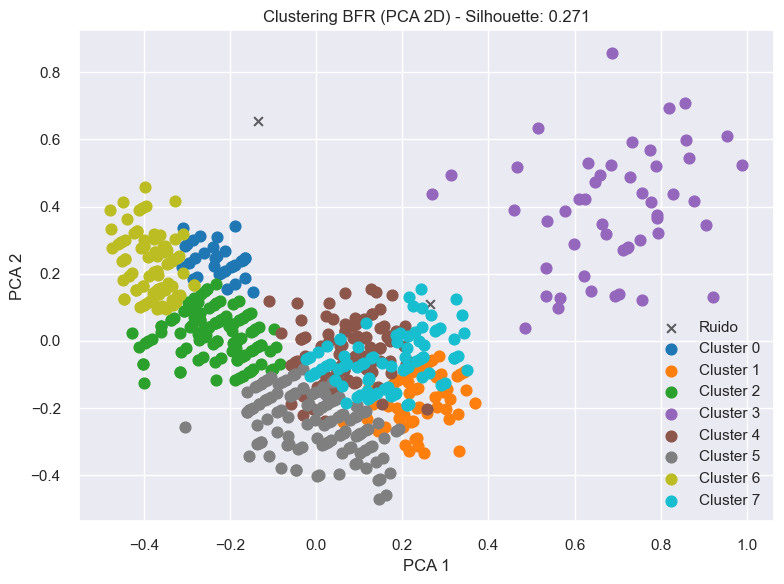

In [561]:
from sklearn.decomposition import PCA
unique_clusters = np.unique(labels[labels!=-1])
if len(unique_clusters) >= 2:
    sil_score = silhouette_score(data_array[labels!=-1], labels[labels!=-1])
    SParaBFR = sil_score
    print(f"Coeficiente de Silhouette (excluyendo ruido): {sil_score:.4f}")
else:
    sil_score = None
    print("No hay suficientes clusters para calcular Silhouette.")

# Plot 2D con PCA
pca = PCA(n_components=2, random_state=42)
points_2d = pca.fit_transform(data_array)

plt.figure(figsize=(8,6))
# ruido 
noise_mask = labels == -1
plt.scatter(points_2d[noise_mask,0], points_2d[noise_mask,1], 
            c='black', marker='x', s=40, label='Ruido', alpha=0.6)

# clusters
cluster_ids = np.unique(labels[labels!=-1])
colors = plt.cm.tab10(np.linspace(0,1,len(cluster_ids)))
for cid, color in zip(cluster_ids, colors):
    mask = labels == cid
    plt.scatter(points_2d[mask,0], points_2d[mask,1],
                c=[color], s=60, label=f'Cluster {cid}')

title = "Clustering BFR (PCA 2D)"
if sil_score is not None:
    title += f" - Silhouette: {sil_score:.3f}"
plt.title(title)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.tight_layout()
plt.show()

## 4. Comparar Resultados

In [562]:
print("Comparación de resultados:")
print(f"KMeans Silhouette: {SParaK:.4f}")
print(f"DBSCAN Silhouette: {SParaDB:.4f}")
print(f"BFR Silhouette: {SParaBFR:.4f}")

Comparación de resultados:
KMeans Silhouette: 0.3286
DBSCAN Silhouette: 0.0580
BFR Silhouette: 0.2710


# Análisis comparativo de resultados de clustering

| Métrica | k-Means | DBSCAN | BFR |
|---------|--------|--------|-----|
| **Silhouette global** | **0.3286** | 0.0580 | 0.2710 |
| **N.º de clusters**   | 4 | 8 (mucho ruido) | 8 (poco ruido) |
| **Ruido detectado**   | — | Alto (puntos dispersos) | Bajo (2 %) |

---

## 1. k-Means  
- **Mejor cohesión/separación:** Silhouette ≈ 0.33.  
- El diagrama de Silhouette muestra que tres de los cuatro clusters tienen coeficientes predominantemente > 0.2; solo el cluster 0 exhibe cierta superposición (coeficientes cercanos a 0).  
- Requiere especificar \(k\); el método del codo justificó \(k=4\).

## 2. DBSCAN  
- **Desempeño pobre:** Silhouette ≈ 0.06 refleja escasa separación entre grupos y gran proporción de puntos etiquetados como **ruido**.  
- El scatter (tarjetas vs. recencia) evidencia clusters delgados y verticales; muchos usuarios quedan aislados (cruces grises).  
- Sensible a la elección de `eps` y `min_samples`; aun tras búsqueda de hiperparámetros no consigue estructura clara.

## 3. BFR (Bradley–Fayyad–Reina)  
- **Resultado intermedio:** Silhouette ≈ 0.27 con 8 clusters finales.  
- El gráfico PCA 2D muestra grupos compactos y bien distribuidos; el ruido es mínimo (dos puntos aislados).  
- Ventaja: procesa por bloques, útil para datasets grandes; en este ejemplo (660 filas) el beneficio principal es flexibilidad frente a outliers.
